In [3]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

warnings.filterwarnings('ignore')

In [7]:
alldata = sc.read_h5ad('new_data/integrated/alldata.h5ad')
alldata1 = sc.read_h5ad('Anndata_Objects/Annotation/alldata.h5ad') # contains the original scVI integrated clustering to reproduce results
alldata.var.index = alldata.var["gene_name"]
alldata = alldata [:, ~alldata.var_names.duplicated(keep='first')].copy()
alldata.X=alldata.layers['log1p_norm']

In [8]:
# at the time of analysis this object did not have saved integrated clustering (it was done after saving the object) so we do a transfer
clustering =alldata1.obs['scVI_res_0.5']
del alldata1

In [9]:
alldata.obs['scVI_res_0.5']=clustering

For annotation it is of importance to visualise gene symbols on the data dor readability. Hence, we have set the .var index (var_names, which is usually displayed by different tools) to gene symbols and also remove the .raw attribute of the data. if present as it preserves the index with which the .raw attribute was originally created and this gets transferred as the real index of the entire object

In [32]:
del alldata.raw

In [6]:
#----OPTIONAL---- to view query embedding
fig, ax = plt.subplots(figsize=(4,3))
sc.pl.umap(alldata, color=['scVI_res_0.5'], legend_loc='on data', show=False, ax=ax)
ax.set_title('scVI Leiden Clustering 0.5', fontsize=12, weight='bold')
plt.show()


Here we perform annotation using DE markers identified with sc.rank_genes_groups() with groups parameter set to None. We need to extract the top 25 markers for the dataset for the given cluster for which we have to make sure that the output of the algorithm is ranked (based on a rank metric considering significance values and log2fold changes)

In [ ]:
    # Code snippet by:
    # Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet 24, 550–572 (2023). 
    # DOI: https://doi.org/10.1038/s41576-023-00586-w
    # with modifications

def get_stats(t_stats):
    '''
    Creates ranked list of scanpy-identified DE marker genes and replaces adjusted p-values of 0 with 1e-300 so that the rank calculation goes through.

    Args:
        t_stats (pd.DataFrame): output dataframe from sc.rank_genes_groups() optimised for current versions' column names.

    Returns:
        pd.DataFrame: ranked dataframe with gene names and ranked by the combined effect of log2foldchanges and p-adj values, with only two columns of 
        names and ranks.
    '''
    epsilon = 1e-300 # remove values of 0 so that the log-transformation works
    t_stats['pvals_adj'] = t_stats['pvals_adj'].replace(0, epsilon)
    t_stats['rank']=-np.log10(t_stats.pvals_adj)*t_stats.logfoldchanges
    t_stats = t_stats.sort_values('rank', ascending=False)
    t_stats.reset_index(inplace=True)
    rank_stats = t_stats[['names', 'rank']]
    return rank_stats

In [33]:
sc.tl.rank_genes_groups(alldata, groupby='scVI_res_0.5', method='t-test', key_added='t-test', gene_symbols='gene_name', use_raw=False)
query_groups = sc.get.rank_genes_groups_df(alldata, group=None, key="t-test")
# sc.pl.rank_genes_groups(alldata, n_genes=25, gene_symbols='gene_name', sharey=False, key="t-test", save='25_genes.png', use_raw=None, layer='log1p_norm')

Here we can visualise the top 5 markers per cluster 

In [ ]:
sc.pl.rank_genes_groups_dotplot(alldata, groupby='scVI_res_0.5', standard_scale='var', layer='log1p_norm', save='dotplot_markers.png', n_genes=5)
# this will save to figures/dotplot_markers.png in wd

In [28]:
query_groups

Sometimes the reference can be in backed mode and not load all components of the object (for example, UMAP coordinates). If we delete the .raw attribute we can also make sure that if we set index to gene symbols for example, it will stay that way

In [12]:
theirdata = sc.read_h5ad('new_data/theirdata.h5ad')
theirdata=theirdata.to_memory()
theirdata = theirdata.copy()
del theirdata.raw
theirdata.var_names=theirdata.var['Symbol']

We obtain the cell type markers of the ref dataset 

In [20]:
sc.tl.rank_genes_groups(theirdata, groupby='celltype', method='t-test', key_added='t-test', gene_symbols='Symbol')
ref_groups = sc.get.rank_genes_groups_df(theirdata, group=None, key="t-test")

In [34]:
# ref_celltype = theirdata.obs['celltype'].unique()
query_celltype = alldata.obs['scVI_res_0.5'].unique()


Here we also read our dataframe of curated markers for every expected cell type in the dataset. The gene columns for the cell types can be of different lengths - then we make sure we remove NaN values later when we extract the gene names.

In [51]:
curated_markers=pd.read_csv('new_data/tables/supplementary_table_02_mariakaraboeva_5244943.csv')

In [1]:
# curated_markers

Here we simply define a function to plot each gene (in normalised counts) on the (the reference or query) embedding if the gene is indeed present in the data.

In [43]:
def plot_embeddings(dataset, folder, gene_names, c):
    '''
    Plotting function called by mapping() which produces UMAP embeddings.

    Args:
        (passed from mapping()):
        dataset (Anndata object)
        folder (str): folder names: 'all' (ref-query), 'their' (query-ref), (plotting own markers (optional))'all_own', 'their_own' and 'markers' (curated markers)
        (own, takes from mapping()):
        gene_names (list): list of str, gene symbols of genes to plot 
        
    Returns:
        None
        
    '''
    for gene in gene_names:
        if gene in dataset.var_names:
            fig, ax = plt.subplots(figsize=(4,3))
            sc.pl.umap(dataset, color=gene, cmap='Reds', show=False, ax=ax)
            ax.set_title(f'{c} - {gene}', fontsize=12, weight='bold')
            plt.savefig(f'new_data/plots/annotation/{folder}/{gene}_{c}.png', dpi=300, bbox_inches='tight') 
            plt.show()

This function allows for mapping of genes in the following ways: plotting query genes on the reference dataset or reference genes on the query dataset; also plotting query/ref genes on their own embeddings and in addition, plotting of curated markers on the query embedding. We cross-plotted only the top highly expressed marker genes for both reference and the query since the most downregulated genes showing up were the same genes as the highly regulated, just in other clusters, confirming the cluster-specific expression of these markers in their source datasets as identified by sc.rank_genes_groups(). 

In [42]:
def mapping(dataset, all_groups, celltype, folder):
    '''
    Produce plots mapping marker genes both ways from reference to query or plot markers on the query dataset. Also plot dataset's own markers on its
    own embedding. Optimised for markers identified by sc.get.rank_genes_groups().

    Args:
        dataset (Anndata object): Anndata object with .X as log-normalised counts for plotting and index as gene symbols. Both reference and query
        should have index as gene symbols. var_names should not have duplicated items. Also passed to plot_embeddings()
        all_groups (pd.DataFrame): output of sc.get.rank_genes_groups_df(group=None). A single dataframe which can be seen as composed of dataframes for
        every celltype. There is a single column "group" with multiple rows grouped by cell type.
        celltype (list or pd.DataFrame): the source object which can be either list of cell type/cluster labels in the dataset or a dataframe containing
        manually curated markers. 
        folder (str): folder name where to store embeddings. Also passed to plot_embeddings().

    Returns:
        None
    '''
    if type(celltype)== list:     # We either iterate through the cluster/cell type markers
        for c in celltype:
            df=all_groups[all_groups["group"] == c]
            df=(get_stats(df))
            gene_names = df.head(25)['names'].tolist()
            plot_embeddings(dataset, folder, gene_names)
    elif type(celltype)==pd.DataFrame:     # or the dataframe with curated markers
        for tissue in celltype.columns:
            gene_names=celltype[tissue].dropna().tolist()
            print(gene_names)
            plot_embeddings(dataset, folder, gene_names, tissue)

In [ ]:
mapping(alldata, ref_groups, ref_celltype, 'ref_to_query') #Example call producing reference to query mapping embeddings

['Cdx2', 'Gata3', 'Tead4', 'P63', 'Eomes', 'Gata2', 'Essrb', 'Dlx3', 'Rxra', 'Pparg', 'Cyp26a1', 'Hand1', 'Atp6v0d2', 'Sdc1', 'Gcm1', 'Ervfrd1', 'Pgf', 'Gcm1', 'Ccr7', 'Cyp19a1', 'Dlx5', 'Muc15', 'Elf5', 'Tfap2ac', 'Arid3a', 'Bhlhe40', 'Ccn31', 'Cdk2', 'Rho', 'Rock', 'Krt7', 'Gata3']
banana


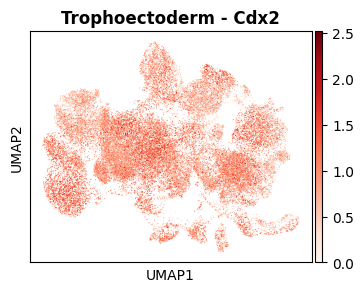

banana


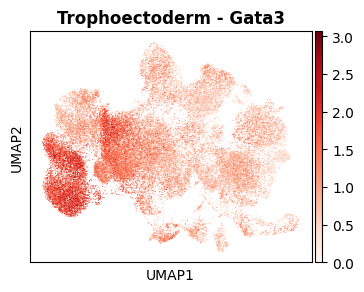

banana


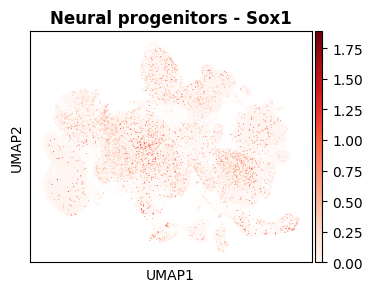

banana


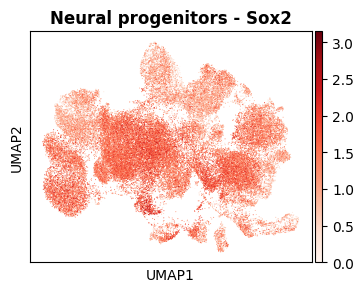

banana


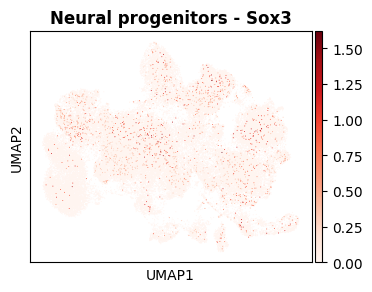

banana


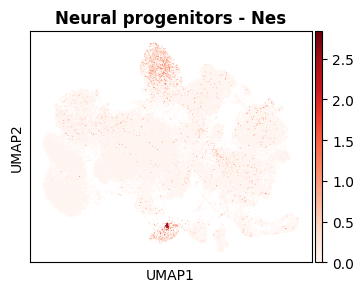

banana


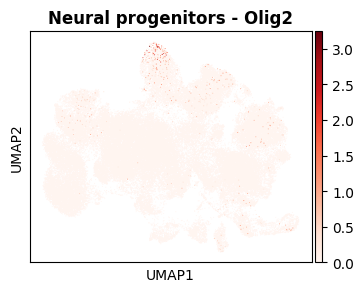

banana
banana


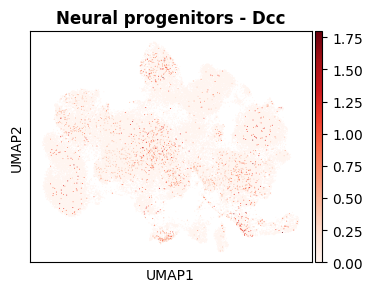

banana


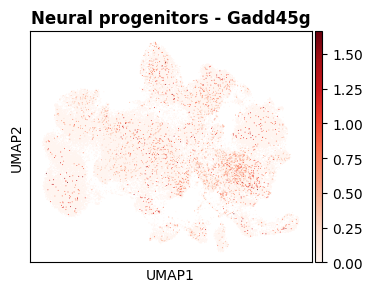

banana
banana


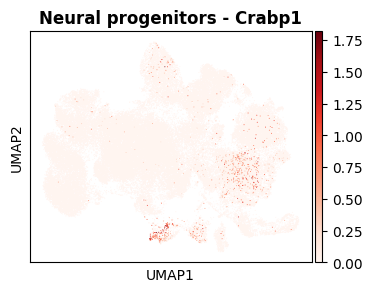

banana


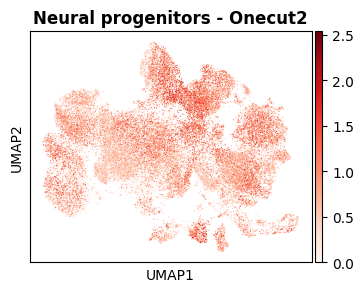

banana


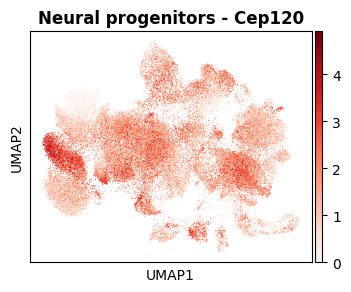

banana
banana
banana


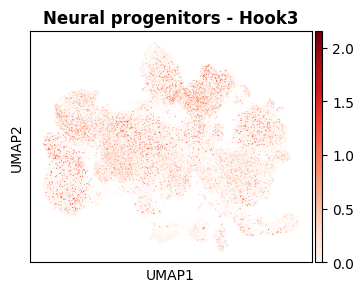

banana


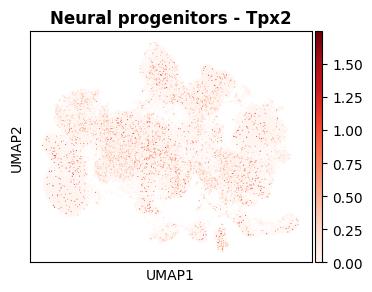

banana
banana


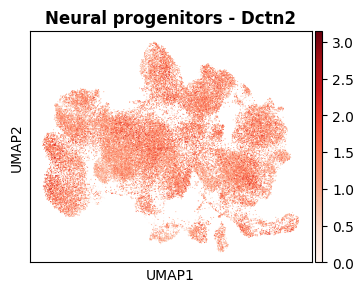

banana


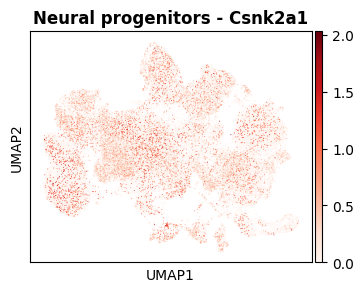

banana


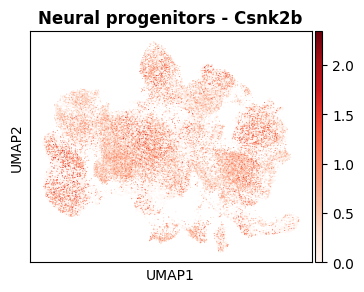

banana


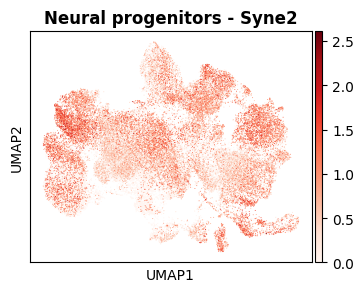

banana


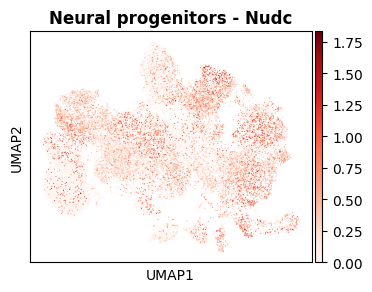

banana


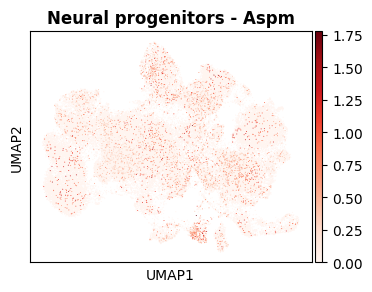

banana


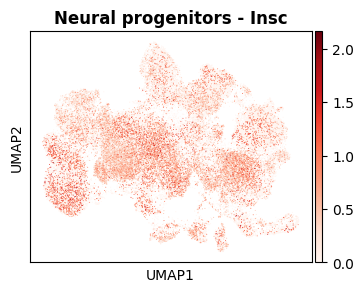

banana
banana


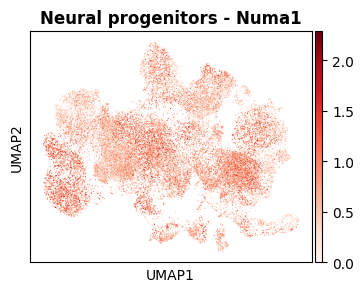

banana


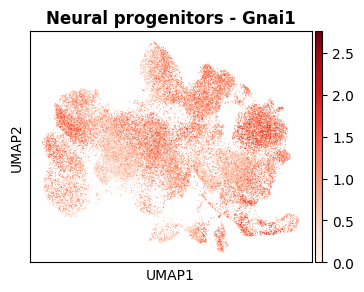

banana


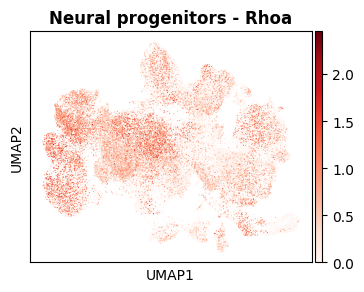

banana
banana


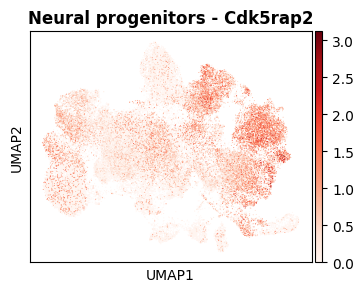

banana


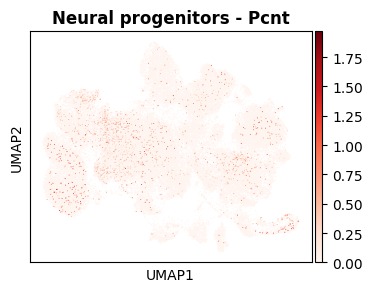

banana


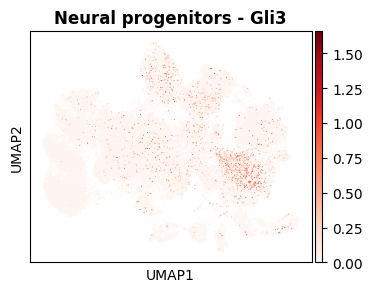

banana
banana


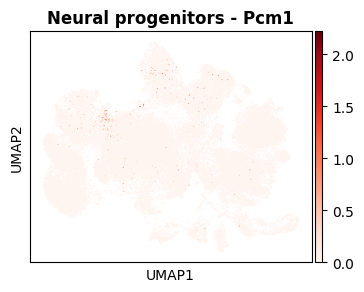

banana
banana


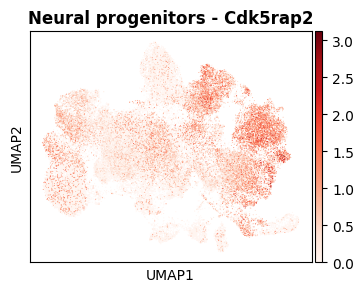

banana


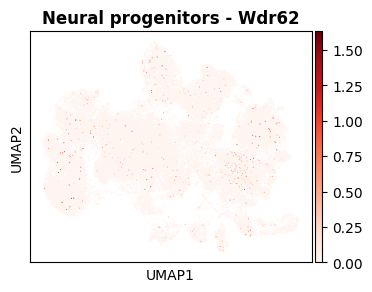

banana


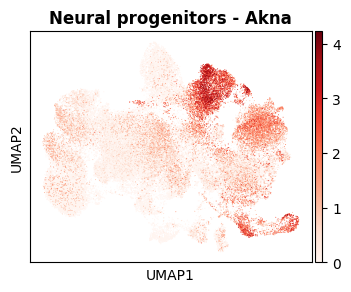

banana


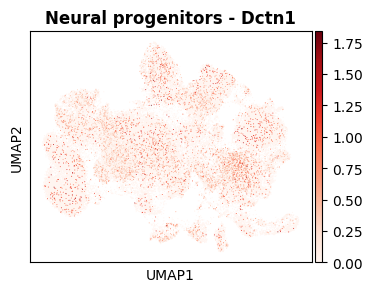

banana


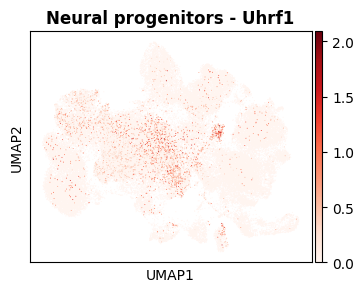

banana


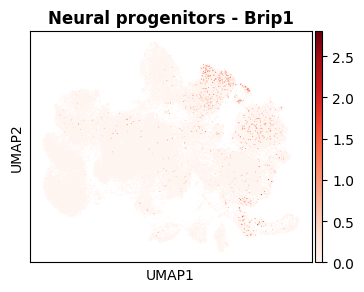

banana


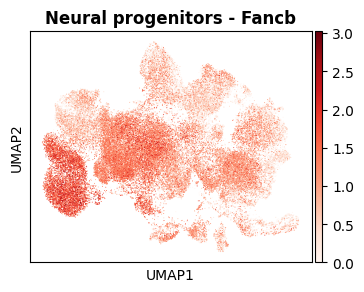

banana


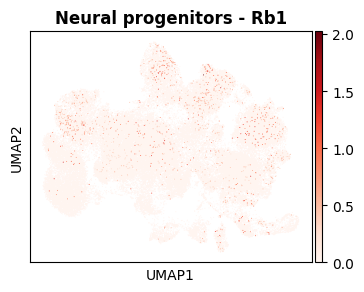

banana


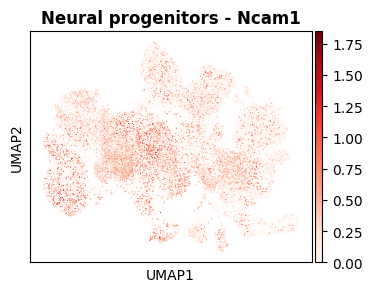

banana
banana
banana


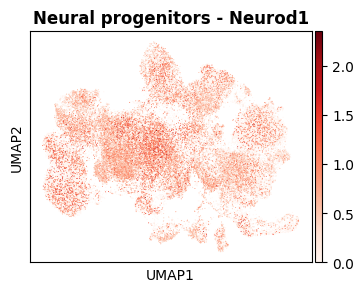

banana


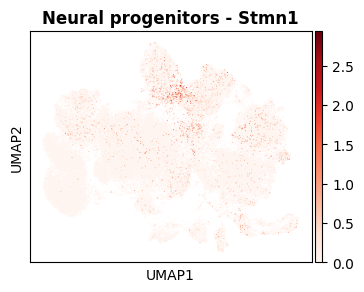

['Nkx2.5', 'Fzd2', 'Tbx5', 'Tbx20', 'Gata6', 'Hand2', 'Actg1', 'Actb', 'Acta2', 'Vsnl1', 'Gucy1a1', 'Tpm2', 'Shox2', 'Ptn', 'Maged2', 'Myh6', 'Casq1', 'Myl7', 'Pam', 'Myl4', 'Itga6', 'Tesc', 'Stard10', 'Palld', 'Nppa', 'Myl2', 'Myl3', 'Myh7', 'Mpped2', 'Pln', 'Hopx', 'Retrag1', 'Mhrt', 'Spink4', 'Mb', 'Mesp1', 'Myod', 'Myf5', 'Pax7', 'Msc', 'Myor', 'Tbx1', 'Pitx2', 'Tcf21', 'Tnni3', 'Ecad', 'Vegfr2', 'Tnnt2', 'Ebf3', 'Isl1', 'Hand1', 'Srf', 'Rspo3', 'Fzd1', 'Sox4', 'Cxxc4', 'Fzd3']
banana
banana


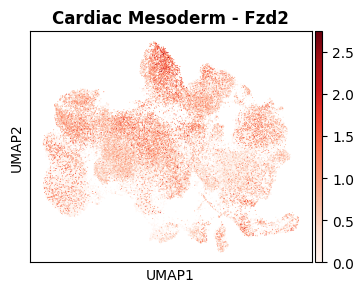

banana


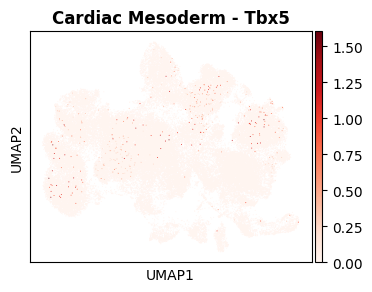

banana


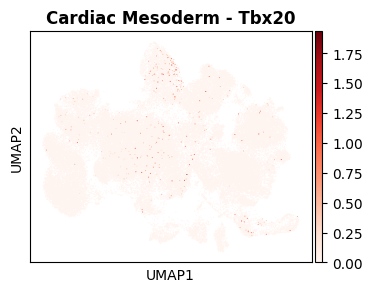

banana


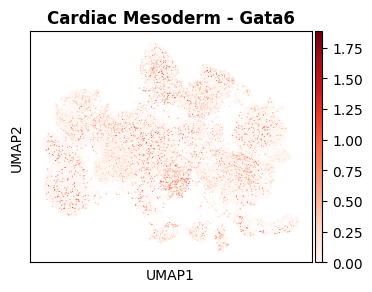

banana


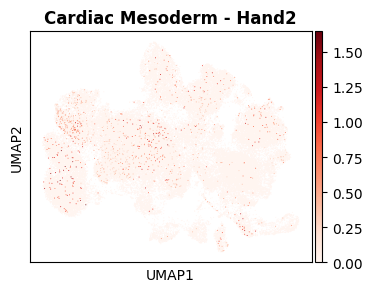

banana


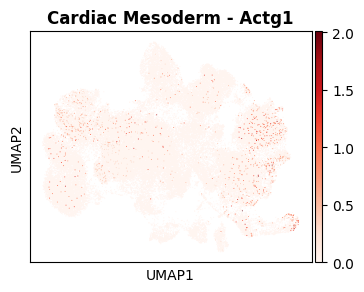

banana


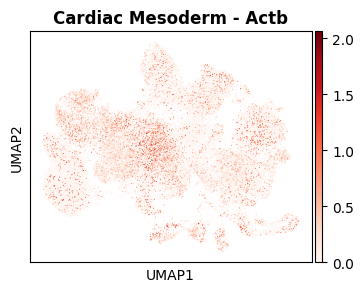

banana


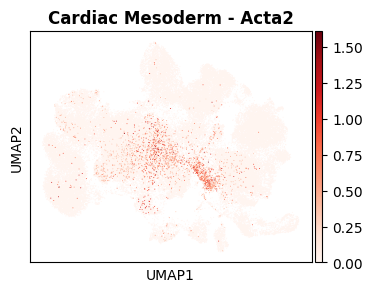

banana


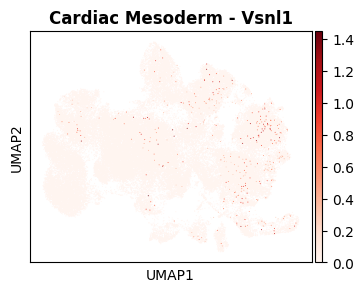

banana


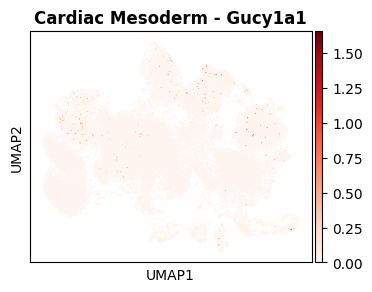

banana


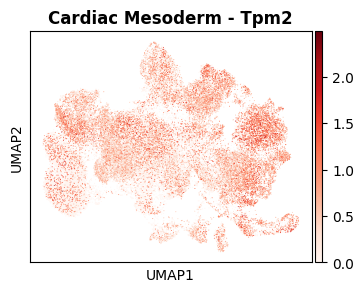

banana


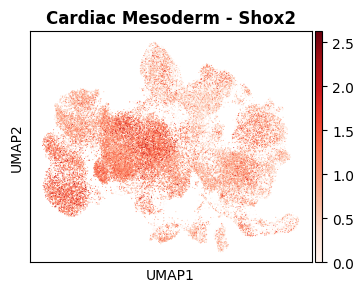

banana


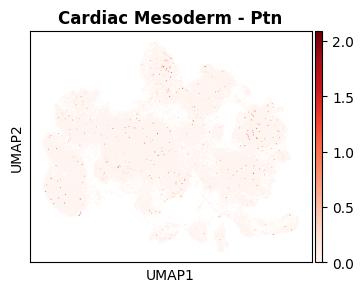

banana


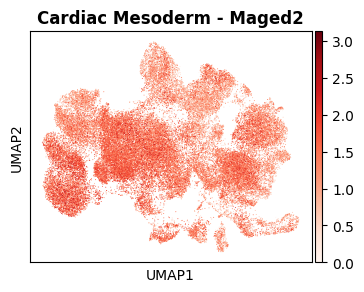

banana


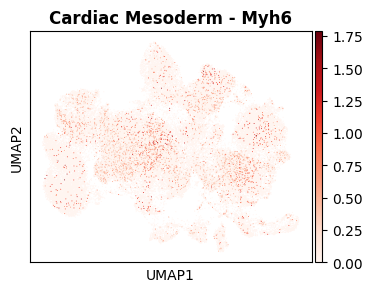

banana


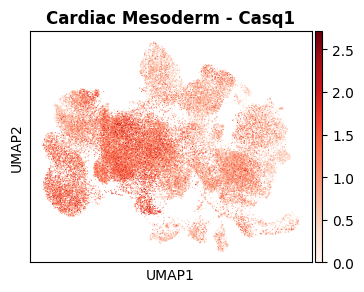

banana


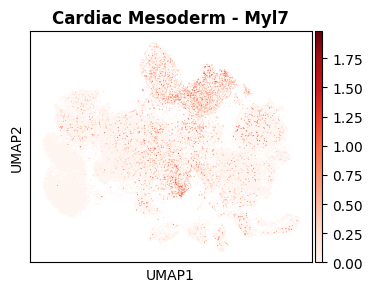

banana


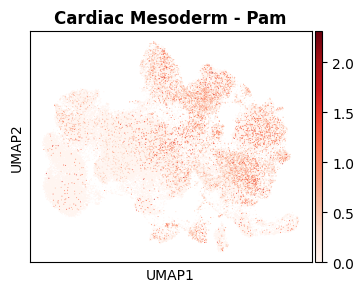

banana


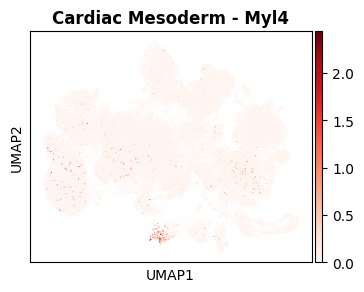

banana


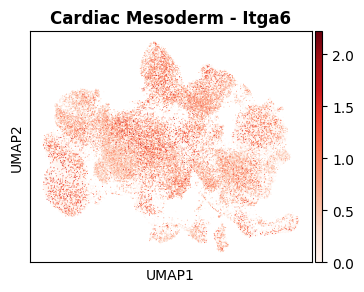

banana


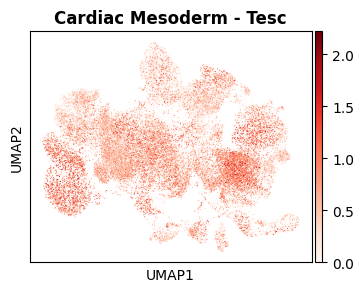

banana


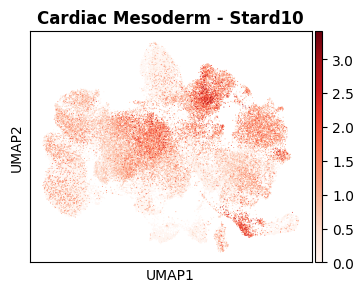

banana


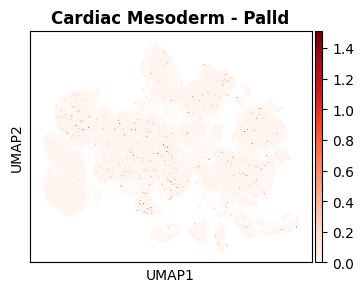

banana


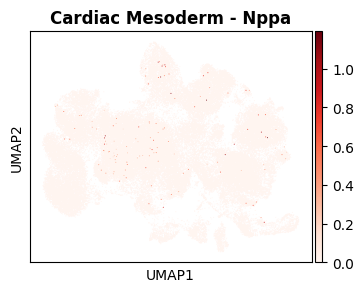

banana


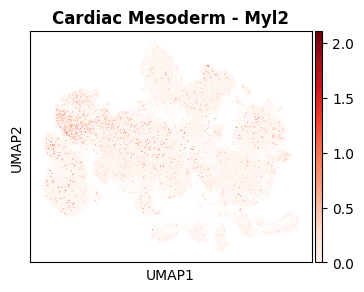

banana


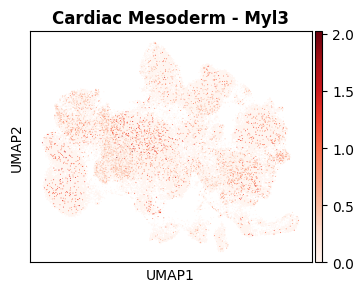

banana


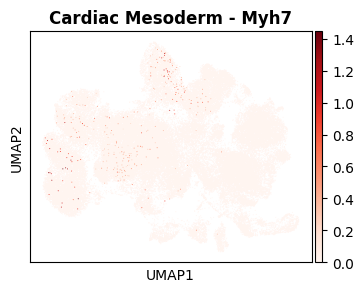

banana


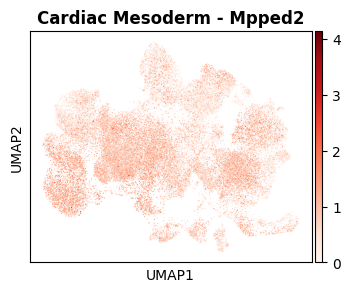

banana
banana


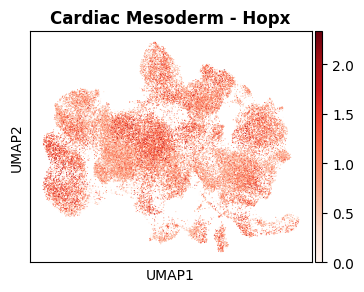

banana
banana
banana


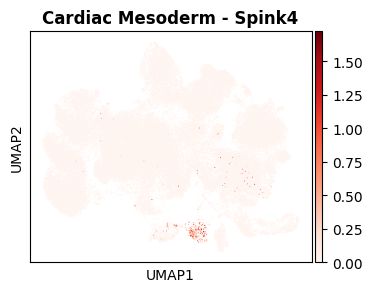

banana


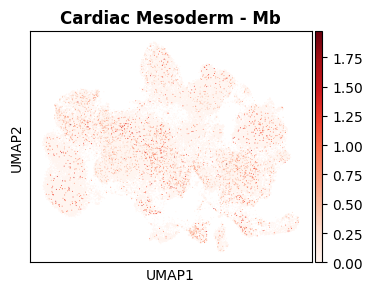

banana


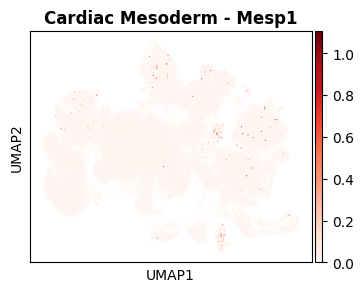

banana
banana
banana


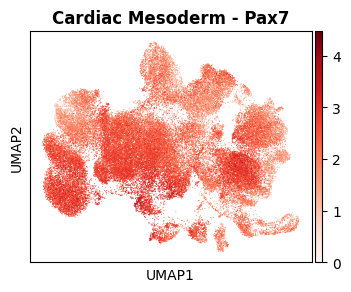

banana


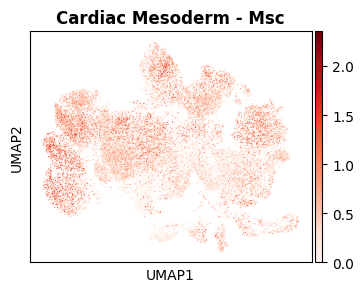

banana
banana
banana


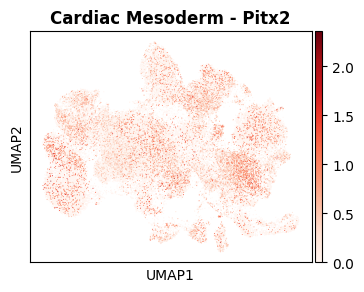

banana


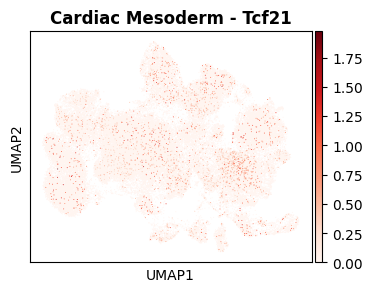

banana


KeyboardInterrupt: 

In [56]:
mapping(alldata, query_groups, curated_markers, 'm')

When we do cross-mapping between query and ref datasets it is important to visualise how this gene maps on its source dataset: this can reveal that it is expressed in more than one clusters there even if its "top" cluster is "Neurons" for example. This is why we plot genes also on the source datasets. 
Next, we assign the annotation labels

In [ ]:
labels = {
    '0': 'Naive\nPluripotent',
    '1': 'Cardiac-like\nMesoderm',
    '2': 'Differentiating\nNeurons',
    '3': 'Epiblast\nPrimitive Streak',
    '4': 'Primed\nPluripotent',
    '5': 'Neural\nProgenitors',
    '6': 'Pluripotent1',
    '7': 'Mesoderm',
    '8': 'Pluripotent2',
    '9': 'Epiblast\nEpidermis',
    '10': 'Hemato-endothelial\nProgenitors 1',
    '11': 'N/A1',
    '12': 'N/A2',
    '13': 'N/A3',
    '14': 'N/A4',
    '15': 'Endoderm',
    '16': 'Contamination'
}

alldata.obs["manual_celltype_annotation"] = alldata.obs['scVI_res_0.5'].map(labels)


In [7]:
fig, ax = plt.subplots(figsize=(4,3))
sc.pl.umap(
    alldata,
    color=["manual_celltype_annotation"],
    legend_fontsize=8,
    na_color="gray",
    use_raw=False,
    layer='log1p_norm',
    show = False,
    ax=ax
)
ax.set_title(f'Manual Cell Type Annotation', fontsize=12, weight='bold')
plt.savefig(f'new_data/plots/annotation/manual_annotation.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
alldata.write_h5ad('new_data/annotated/alldata.h5ad', compression="gzip")